In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings('ignore')

In [20]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [53]:
model = "LinearNoInt"
mode = "MeanSubFiringRate"
alpha = 0.05

def get_results(session): 
    res_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat.pickle"
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID

    shuffle_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat_shuffles.pickle"
    shuffles = pd.read_pickle(os.path.join(OUTPUT_DIR, shuffle_name))
    sig_bounds = shuffles.groupby("split_idx").apply(lambda group: glm_utils.calculate_sig_stats(group, alpha, 1, "test_score")).reset_index()
    merged = pd.merge(res, sig_bounds, on=["UnitID", "split_idx"])
    return merged
# sig = glm_utils.calculate_sig_stats(shuffles, )
# return res
# glm_res = pd.concat(sessions.apply(lambda x: get_agg_glm_res(x.session_name), axis=1).values)

In [54]:
glm_res = pd.concat(sessions.apply(lambda x: get_results(x.session_name), axis=1).values)

In [55]:
good_reses = glm_res[(glm_res.test_score > 0.1) & (glm_res.test_score > glm_res.sig_bound)]

In [56]:
good_reses.groupby("PseudoUnitID").split_idx.nunique()

PseudoUnitID
2018070900    1
2018070903    1
2018070904    1
2018070912    1
2018071206    1
2018071216    1
2018071221    1
2018091804    2
2018092402    1
2018092513    1
Name: split_idx, dtype: int64

In [64]:
glm_res[glm_res.YELLOW_coef < 0]

,UnitID,TimeBins_x,train_score,test_score,YELLOW_coef,SWIRL_coef,SQUARE_coef,ESCHER_coef,POLKADOT_coef,STAR_coef,...,CYAN_coef,TRIANGLE_coef,CIRCLE_coef,GREEN_coef,split_idx,session,PseudoUnitID,level_1,TimeBins_y,sig_bound
2,2,0,0.017879,0.000000,-7.703720e-34,0.069767,0.069767,0.052632,0.019231,0.000000e+00,...,0.034483,0.0,0.000000,3.777055e-18,0,20181002,2018100202,2,0,0.000000
91,22,0,0.006520,0.013931,-7.703720e-34,0.054054,0.025641,0.054054,0.032787,0.000000e+00,...,0.000000,0.0,0.000000,6.168958e-18,3,20181002,2018100222,22,0,0.017756
9,9,0,0.026274,-0.156946,-5.172245e-19,0.022222,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.0,0.020833,0.000000e+00,0,20181010,2018101009,9,0,-0.020654
34,16,0,0.033124,-0.036812,-5.514968e-20,0.061224,0.000000,0.000000,0.148148,4.420332e-17,...,0.000000,0.0,0.000000,0.000000e+00,1,20181010,2018101016,16,0,0.012495
45,9,0,0.027931,0.000000,-3.306541e-19,0.022727,0.000000,0.000000,0.000000,9.629650e-35,...,0.000000,0.0,0.037736,0.000000e+00,2,20181010,2018101009,9,0,0.000000


In [58]:
positions = spike_utils.get_unit_positions(sessions)
merged_res = pd.merge(positions, glm_res, on="PseudoUnitID")

In [59]:
merged_res.columns

Index(['Channel', 'Unit', 'SpikeTimesFile', 'UnitID_x', 'electrode_id', 'x',
       'y', 'z', 'distance', 'in_brain', 'tissue', 'structure_level1',
       'structure_level2', 'structure_level3', 'structure_level4',
       'structure_level5', 'structure_level6', 'structure_potential',
       'session_x', 'PseudoUnitID', 'manual_structure', 'UnitID_y',
       'TimeBins_x', 'train_score', 'test_score', 'YELLOW_coef', 'SWIRL_coef',
       'SQUARE_coef', 'ESCHER_coef', 'POLKADOT_coef', 'STAR_coef',
       'MAGENTA_coef', 'RIPPLE_coef', 'CYAN_coef', 'TRIANGLE_coef',
       'CIRCLE_coef', 'GREEN_coef', 'split_idx', 'session_y', 'level_1',
       'TimeBins_y', 'sig_bound'],
      dtype='object')

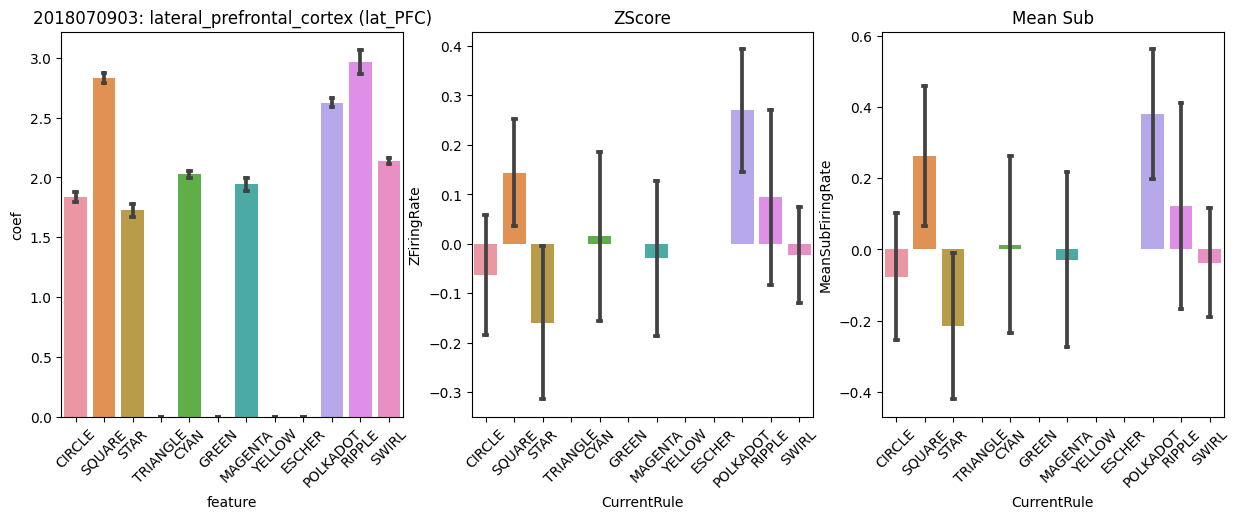

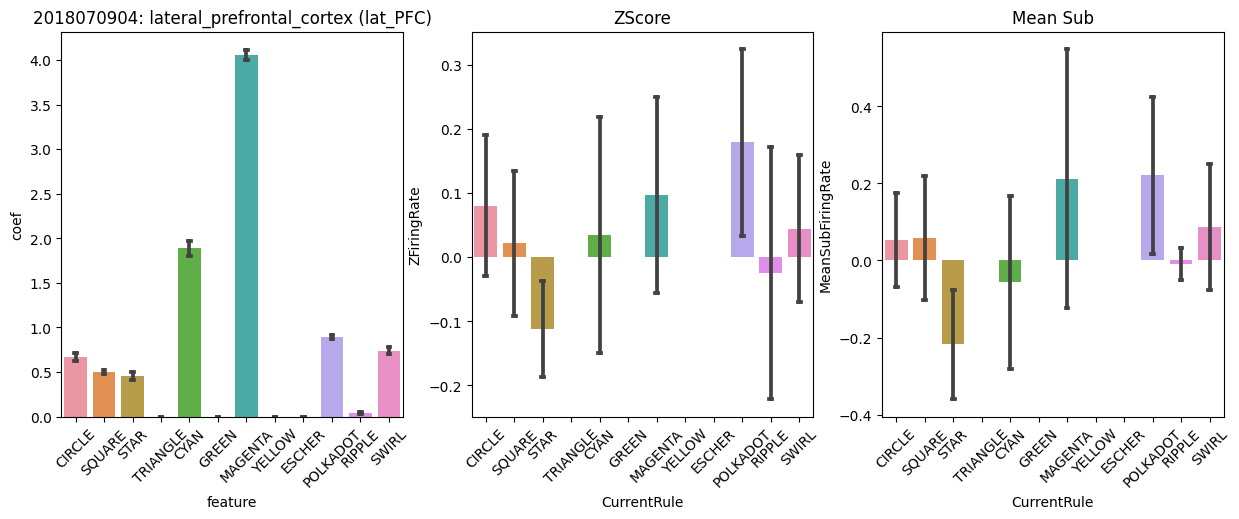

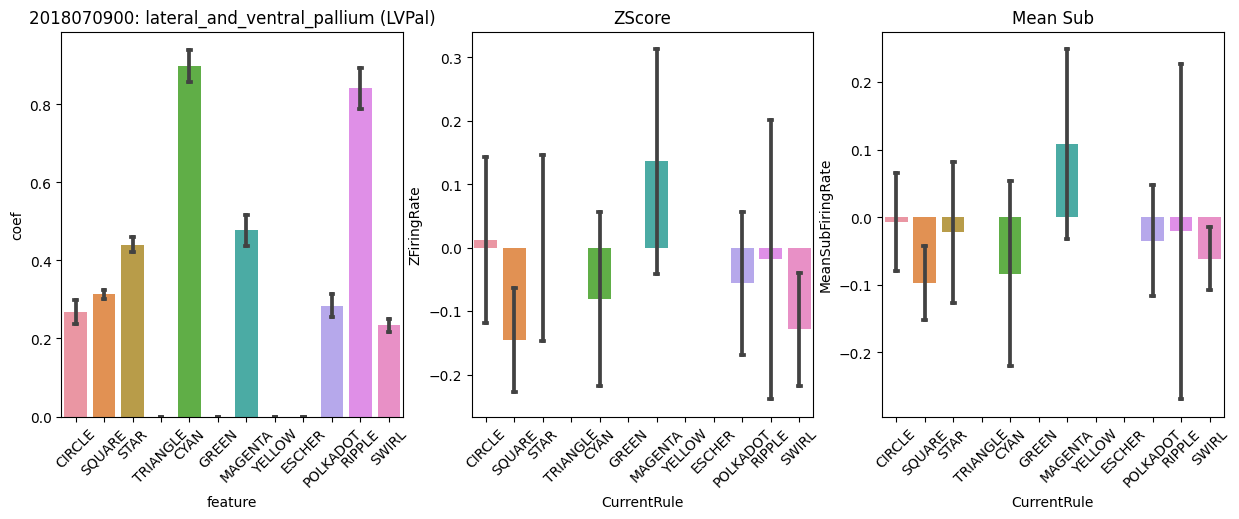

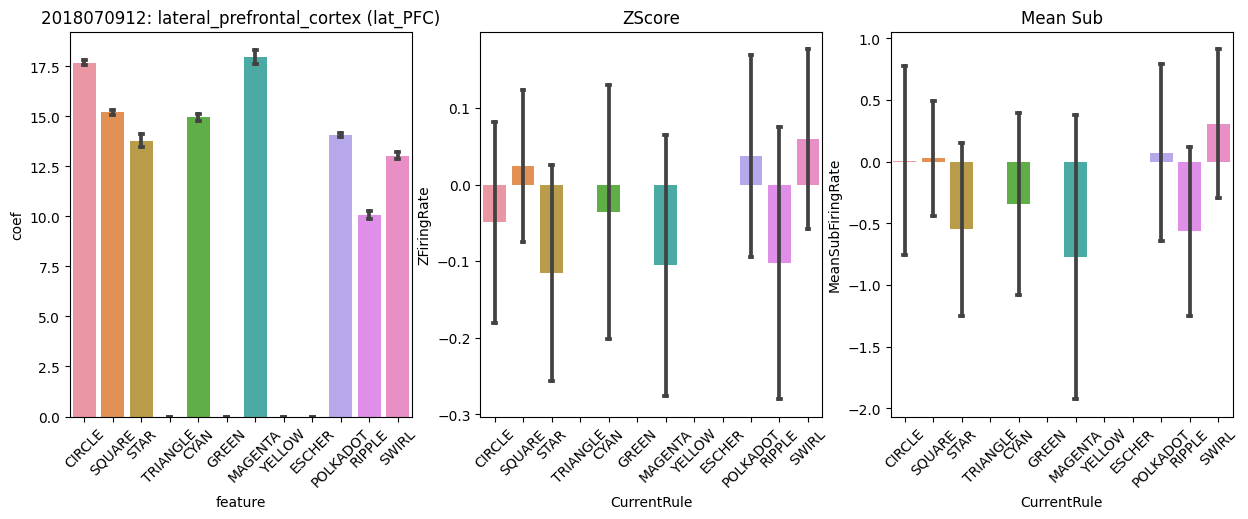

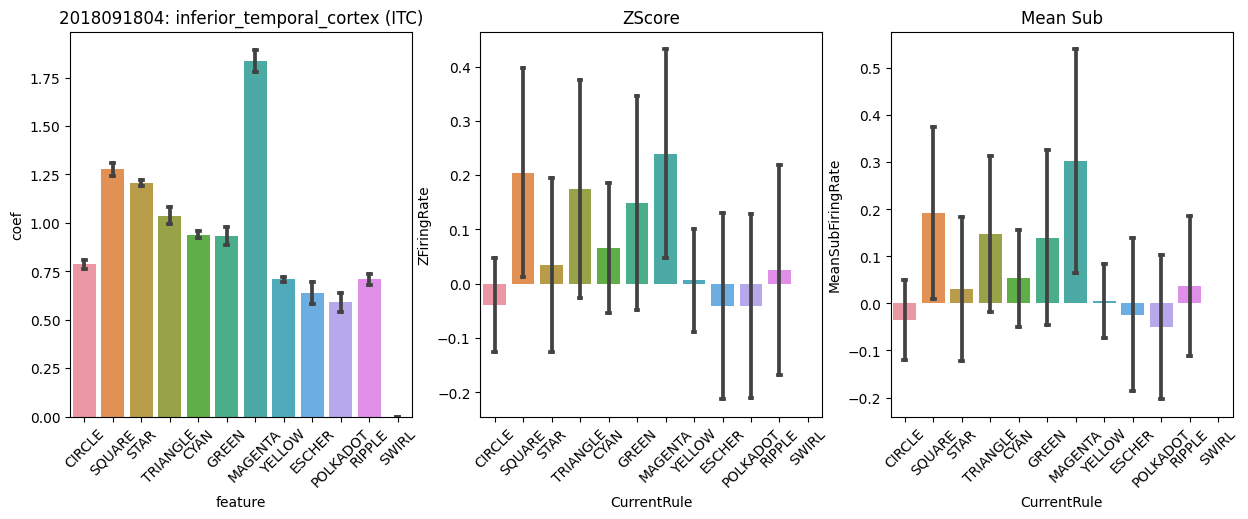

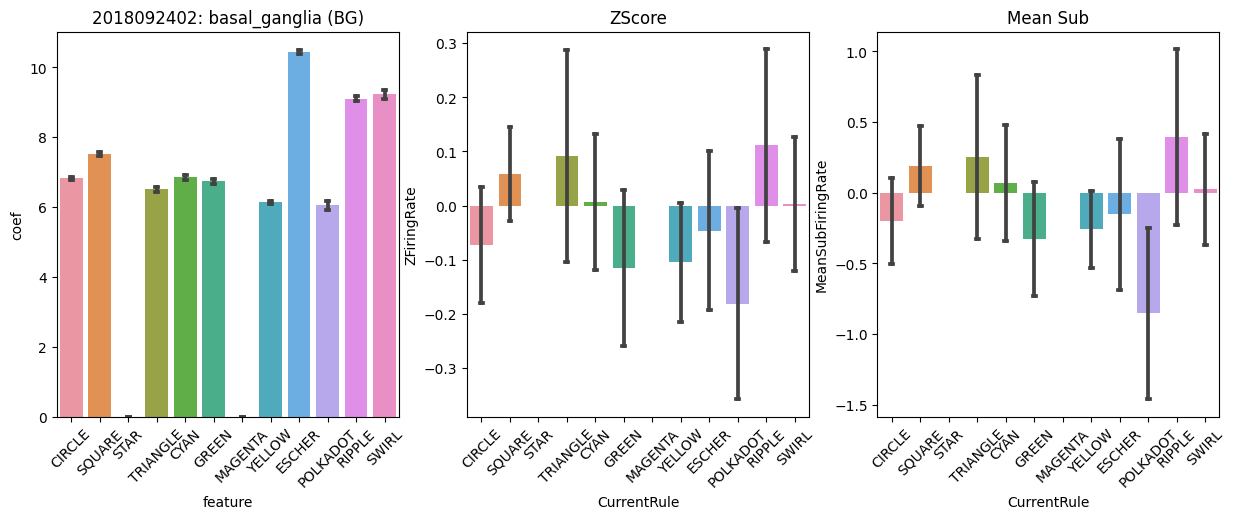

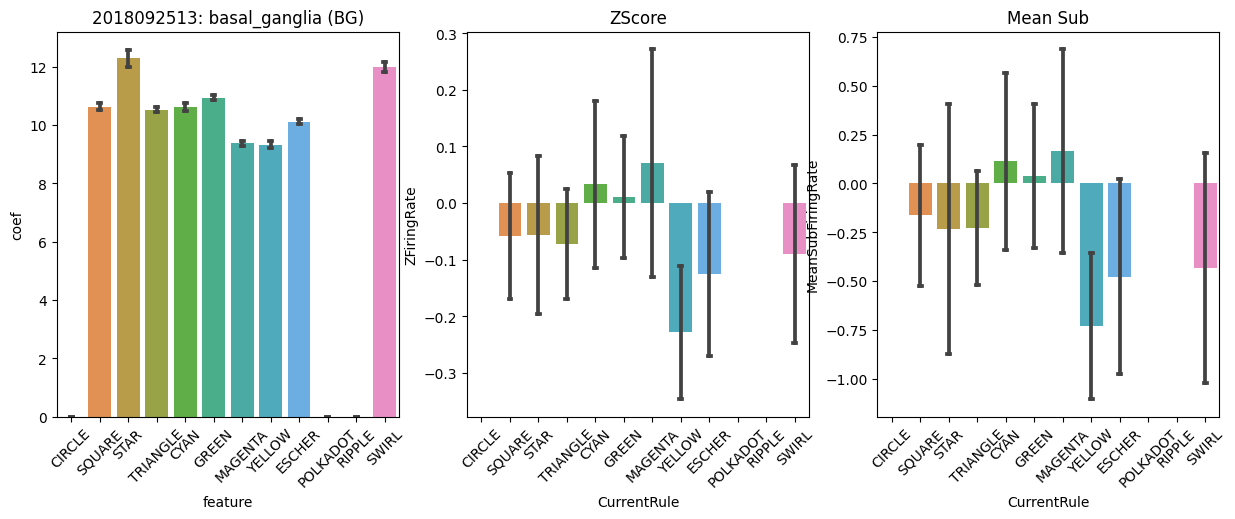

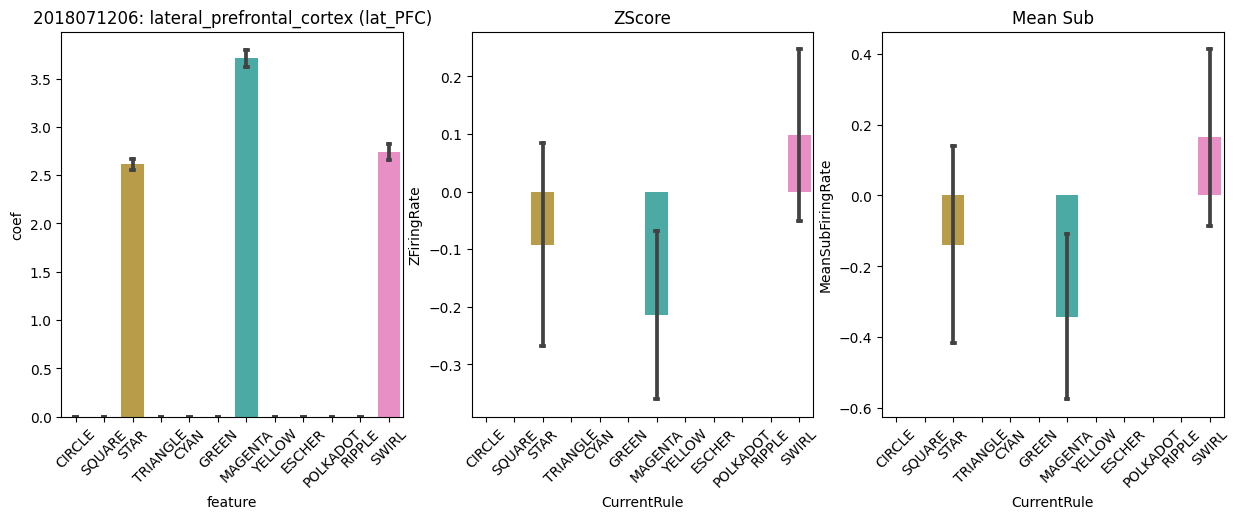

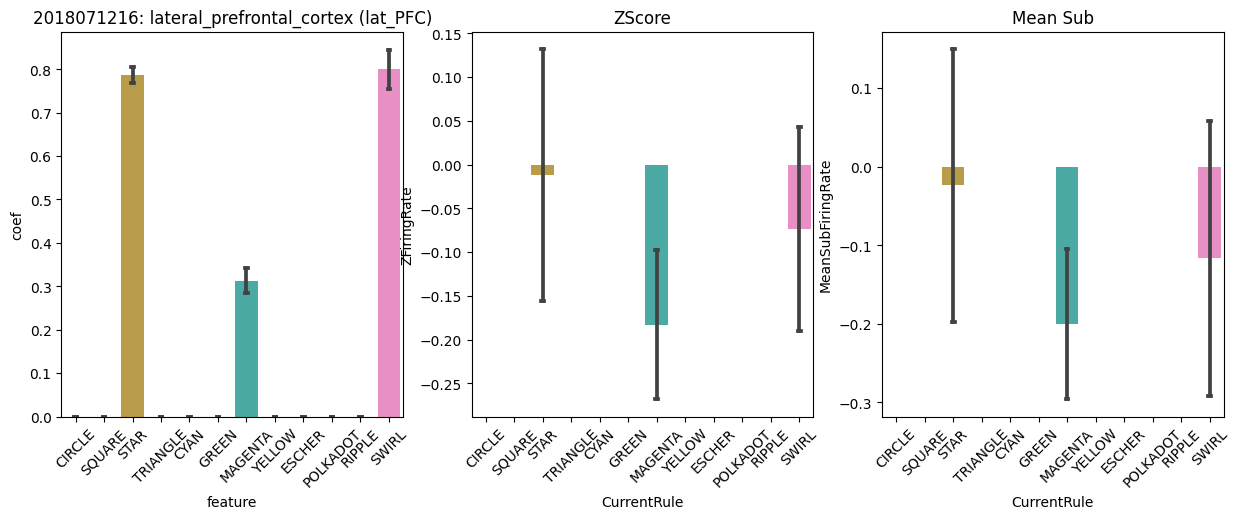

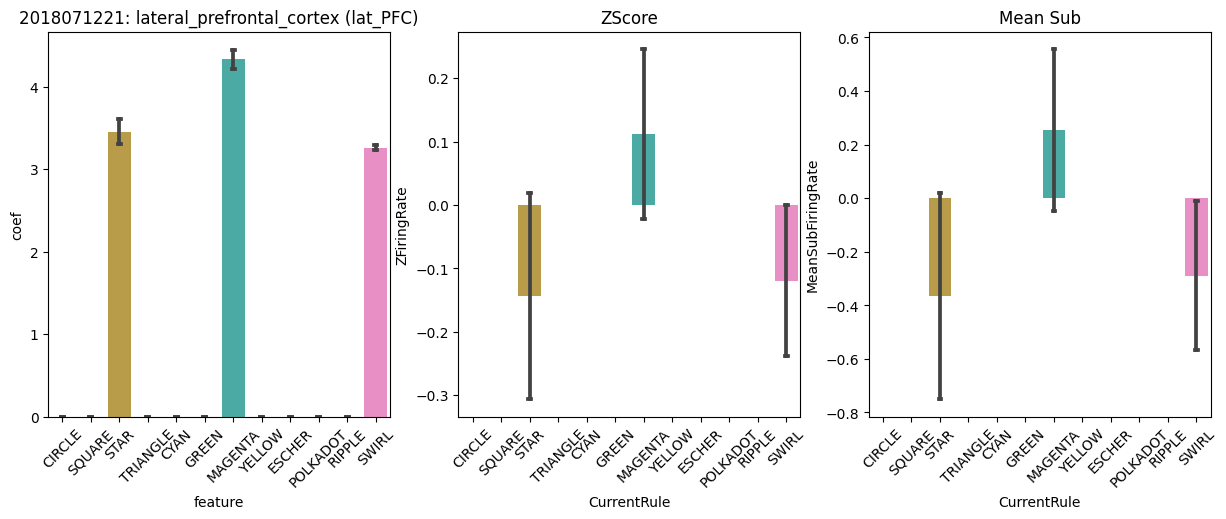

In [62]:
for unit in good_reses.PseudoUnitID.unique():
# for unit in [2018091204]:
    unit_res = merged_res[merged_res.PseudoUnitID == unit]
    session = unit_res.iloc[0].session_x
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber")
    beh = behavioral_utils.get_feature_values_per_session(session, beh)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == unit_res.iloc[0].UnitID_x]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    agg = pd.merge(beh[["TrialNumber", "BlockNumber", "CurrentRule"]], agg, on="TrialNumber")
    agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
    agg = spike_utils.mean_sub_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)

    beh = behavioral_utils.filter_blocks_by_rule_occurence(beh, 2)
    beh = behavioral_utils.filter_max_feat_correct(beh)

    agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]

    rename_map = {f"{feat}_coef": feat for feat in FEATURES}
    unit_res = unit_res.rename(columns=rename_map)
    melted = pd.melt(unit_res, value_vars=FEATURES, var_name="feature", value_name="coef")

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    ax = axs[0]
    visualization_utils.plot_bars_by_cat(melted, "coef", "feature", ax, order=FEATURES)
    ax.set_title(f"{unit}: {unit_res.iloc[0].structure_level2}")

    ax = axs[1]
    visualization_utils.plot_bars_by_cat(agg, "ZFiringRate", "CurrentRule", ax, order=FEATURES)
    ax.set_title("ZScore")

    ax = axs[2]
    visualization_utils.plot_bars_by_cat(agg, "MeanSubFiringRate", "CurrentRule", ax, order=FEATURES)
    ax.set_title("Mean Sub")


In [40]:
agg

,TrialNumber,BlockNumber,CurrentRule,UnitID,TimeBins,SpikeCounts,FiringRate,MeanSubFiringRate
32,89,3,RIPPLE,4,0.475,0.10,2.0,1.812500
33,90,3,RIPPLE,4,0.475,0.00,0.0,-0.187500
34,91,3,RIPPLE,4,0.475,0.00,0.0,-0.187500
37,94,3,RIPPLE,4,0.475,0.00,0.0,-0.187500
38,95,3,RIPPLE,4,0.475,0.00,0.0,-0.187500
...,...,...,...,...,...,...,...,...
1114,1173,29,YELLOW,4,0.475,0.10,2.0,0.673469
1115,1174,29,YELLOW,4,0.475,0.05,1.0,-0.326531
1116,1175,29,YELLOW,4,0.475,0.00,0.0,-1.326531
1118,1177,29,YELLOW,4,0.475,0.15,3.0,1.673469


### Try to figure out what's going on with GLM fitting

In [41]:
session = 20180912
unit_id = 4
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber")
beh = behavioral_utils.get_feature_values_per_session(session, beh)

fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"
frs = pd.read_pickle(fr_path)
frs = frs[frs.UnitID == unit_id]
agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
agg = pd.merge(beh[["TrialNumber", "BlockNumber", "CurrentRule"]], agg, on="TrialNumber")
agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
agg = spike_utils.mean_sub_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)

beh = behavioral_utils.filter_blocks_by_rule_occurence(beh, 3)
beh = behavioral_utils.filter_max_feat_correct(beh)

agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]

In [43]:
input_columns = ["CurrentRule"]
columns_to_flatten = ["CurrentRule"]
not_flattened_columns = [col for col in input_columns if col not in columns_to_flatten]
data, flattened_columns = glm_utils.flatten_columns(agg, columns_to_flatten)
glm_columns = flattened_columns + not_flattened_columns
# res = data.groupby(["UnitID", "TimeBins"]).apply(
#     lambda x: glm_utils.fit_glm(x, glm_columns, mode, model_type, include_predictions, train_test_split)
# ).reset_index()

In [44]:
from sklearn.linear_model import (
    PoissonRegressor,
    LinearRegression,
    Ridge,
)
model = LinearRegression(fit_intercept=False)
ys = data["MeanSubFiringRate"].values
xs = data[glm_columns].values

<Axes: >

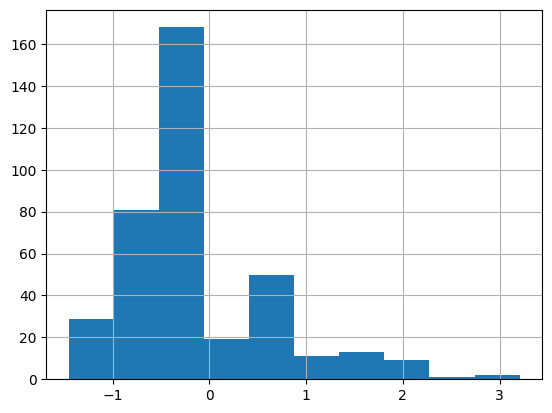

In [45]:
data["MeanSubFiringRate"].hist()

In [46]:
model = model.fit(xs, ys)


In [47]:
xs.shape

(383, 5)

In [48]:
model.coef_

array([-0.09057875, -0.07739352, -0.26055128, -0.06745858, -0.15584416])

In [50]:
glm_columns

['RIPPLE', 'YELLOW', 'MAGENTA', 'GREEN', 'CYAN']

In [36]:
xs.shape

(383, 5)

In [11]:
from numpy.linalg import inv, matrix_rank
# exs = np.hstack((np.ones((383, 1)), xs[:, 1:]))
# exs = np.hstack((np.ones((383, 1)), xs))
exs = xs

beta = inv(exs.T @ exs) @ exs.T @ ys
# beta = inv(xs.T @ xs) @ xs.T @ ys

In [12]:
len(exs[:, 0])

383

In [13]:
beta

array([-0.09057875, -0.07739352, -0.26055128, -0.06745858, -0.15584416])

In [19]:
np.mean(ys[xs[:, 0] == 1])

-0.09057875264270614

In [46]:
-0.09057875 + 0.01318523

-0.07739352